In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import random
import time
import whisper
import numpy as np
import warnings

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import get_base_tensor_directories, generate_batch, process_data, add_ae_tensor, get_ensemble_data, generate_batch_ensemble, generate_autoencoder_batch
from util.audio_utilities import extract_embeddings, extract_audio

In [2]:
# Preprocessing paramemter & ConvLSTMAutoencoder
DEVICE = 'cpu' #get_device() # CPU or GPU
DATASET = 'video_pack_1000'
FRAME_SKIP = 200 # how many frame to skip, reduce depth
SHRINK = 8 # shrink the scale (H x W)//N
NORMALIZE = False # normalize the pixel to 0 to 1
PAD_ALL = False # pad all tensors with max depth
BATCH_SIZE = 4

In [3]:
# ConvLSTMAutoencoder Hyper-Parameters
LEARNING_RATE = 1e-4
EPOCHS = 200
HIDDEN_SIZE = 64 # ConvLSTMAutoencoder hidden size

In [4]:
# Transformer Visual & Audio Hyper-Parameters
NUM_HEADS = 4 # number of attenion heads
HIDDEN_DIM = 32 # Transformer hidden size
NUM_LAYERS = 2 # number of Transformer layers

# EnsembleModel Hyper-Parameters
LEARNING = 1e-9
THE_EPOCHS = 7
AUDIO_TRANSFORMER = True # if False, will skip audio transfomer part #NOT WORKING YET
LATE_FUSION = True # early fusion or late fusion #NOT WORKING YET

In [5]:
x_dir, y_dir = get_base_tensor_directories(input_type=DATASET)

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)]) 
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])

In [6]:
# load all visual tensors
x_data = [torch.load(f) for f in x_files] 
y_data = [torch.load(f) for f in y_files] 

# split the data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
print(x_train[0].size())
print(x_val[0].size())
print(len(y_train))
print(len(y_val))

torch.Size([3, 2, 128, 72])
torch.Size([3, 15, 128, 72])
800
200


In [7]:
# Create AutoEncoder Batches with DataLoaders
batch_size = BATCH_SIZE
train_loader = list(zip(x_train, x_train))
val_loader = list(zip(x_val, x_val))
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True, collate_fn=generate_autoencoder_batch)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_autoencoder_batch)

# check size Batch, Channel, Frame, Height, Width
data, targets = next(iter(train_loader))
data.size(), targets.size()

(torch.Size([4, 3, 11, 128, 72]), torch.Size([4, 3, 11, 128, 72]))

In [8]:
from models import ConvLSTMAutoencoder

autoencoder = ConvLSTMAutoencoder(hidden_dim=HIDDEN_SIZE, shrink=SHRINK, normalize=NORMALIZE)
autoencoder = autoencoder.to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

Total parameters: 1,041,859


In [9]:
ECHO = 1 # print in N epoch only when training
SAVE_NAME = 'ConvLSTMAutoencoder_hidden_weights.pt' # save the weights
autoencoder_load = False

In [10]:
# load check point
weights_file = f'../models/save/{SAVE_NAME}'
autoencoder.load_state_dict(torch.load(weights_file)['model_state_dict'])
autoencoder_load = True
train_losses = torch.load(weights_file)['train_losses']
val_losses = torch.load(weights_file)['val_losses']

In [11]:
if not autoencoder_load:
    # save model if better or not exists
    model_weights = {'model_state_dict': autoencoder.state_dict(), 'val_loss': avg_train_loss, 'train_losses':train_losses, 'val_losses':val_losses}
    weights_file = f'../models/save/{SAVE_NAME}'
    if not os.path.isfile(weights_file):
        # save new
        torch.save(model_weights, weights_file)
        print('save new model')
    elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
        # replace
        torch.save(model_weights, weights_file)
        print('replace old model')
    else:
        print('old model perform better')

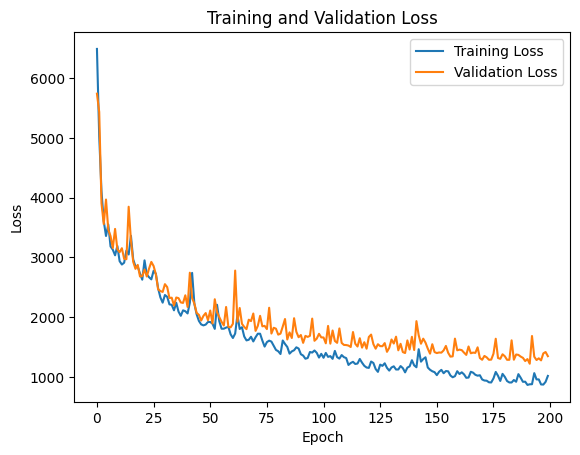

In [12]:
# loss plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Actual:
torch.Size([3, 128, 72])


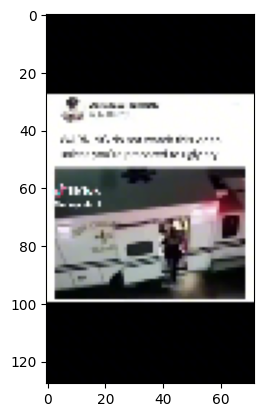

torch.Size([3, 128, 72])


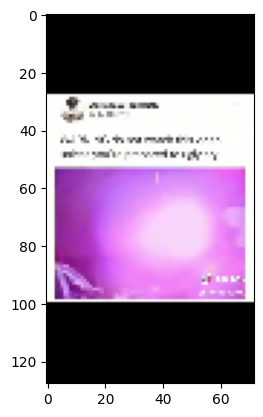

torch.Size([3, 128, 72])


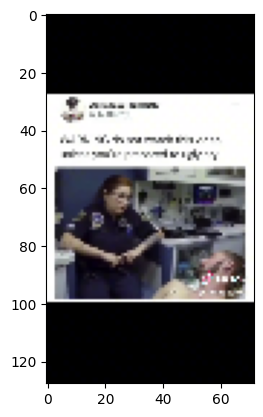

AutoEncoder:


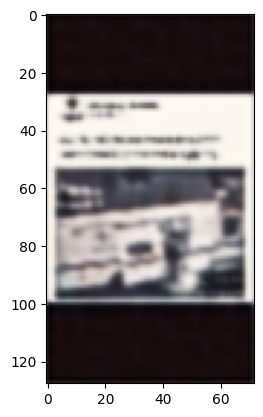

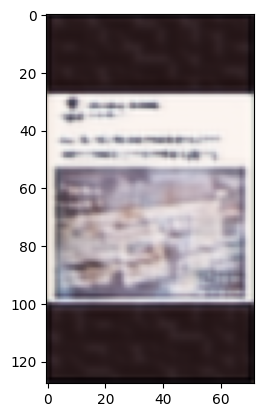

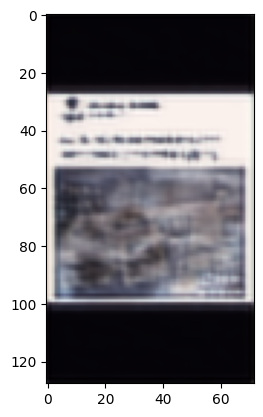

In [13]:
# Random sample inspection
random_num = random.randint(0, len(val_loader)-1)

for i, (inputs, targets) in enumerate(val_loader):
    if i == random_num:  # random sample
        inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        outputs = autoencoder(inputs).detach()
        break

# Actual
print('Actual:')

num_check = min(3,len(targets[0,0,:,0,0]))

for i in range(num_check):
    # select first 3 frame
    image_tensor = targets[0,:,i,:,:]
    print(image_tensor.size())
    numpy_image = image_tensor.detach().numpy()

    # imshow (Height, Width, Channels)
    numpy_image = numpy_image.transpose((1, 2, 0))
    
    # clean unreadable pixel
    numpy_image[np.isinf(numpy_image)] = 0
    numpy_image[np.isnan(numpy_image)] = 0
    
    # normalize to 0,1
    numpy_image = (numpy_image - numpy_image.min()) / (numpy_image.max() - numpy_image.min())

    plt.imshow(numpy_image)
    plt.show()
    
# AutoEncoder
print('AutoEncoder:')
for i in range(num_check):
    # select first 3 frame
    image_tensor = outputs[0,:,i,:,:]
    numpy_image = image_tensor.detach().numpy()

    # imshow (Height, Width, Channels)
    numpy_image = numpy_image.transpose((1, 2, 0))
    
    # clean unreadable pixel
    numpy_image[np.isinf(numpy_image)] = 0
    numpy_image[np.isnan(numpy_image)] = 0
    
    # normalize to 0,1
    numpy_image = (numpy_image - numpy_image.min()) / (numpy_image.max() - numpy_image.min())

    plt.imshow(numpy_image)
    plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler
output_scaler = StandardScaler()

# load ensemble data
x_data, y_data = get_ensemble_data(x_files, DATASET)
y_data = torch.stack(y_data)
y_data = y_data.squeeze(1)

y_data = torch.tensor(output_scaler.fit_transform(y_data.numpy()), dtype=torch.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)

train_loader = list(zip(x_train, y_train))
val_loader = list(zip(x_val, y_val))
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True, collate_fn=generate_batch_ensemble)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_batch_ensemble)

print(f'Train set size: {len(x_train)}')
print(f'Val set size: {len(x_val)}')

Train set size: 800
Val set size: 200


In [15]:
from models import TransformerModel_Visual, TransformerModel_Audio, EnsembleModel

model1 = TransformerModel_Visual(
d_model = 9216,
nhead = NUM_HEADS,
d_hid = HIDDEN_DIM,
nlayers = NUM_LAYERS,
    dropout= 0.1
)

model2 = TransformerModel_Audio(
d_model = 512,
nhead = NUM_HEADS,
d_hid = HIDDEN_DIM ,
nlayers = NUM_LAYERS,
    dropout= 0.1
)

ensemble_model = EnsembleModel(model1,model2)#, deep=True)
total_params = sum(p.numel() for p in ensemble_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

Total parameters: 836,484,738


In [16]:
# Training
def ensemble_train(ensemble_model, autoencoder, dataloader, criterion, optimizer, device='cpu', verbose=False):
    ensemble_model.train()
    total_loss = 0.0
    for visuals, audio_embeds, targets in tqdm(dataloader):
        visuals, audio_embeds, targets = visuals.to(device), audio_embeds.to(device), targets.to(device)
        visual_embeds = autoencoder.getembedding(visuals)#.detach()
        outputs = ensemble_model.forward(visual_embeds, audio_embeds)
        
        if torch.isnan(outputs).any():
            raise ValueError('Tensor contains NaN values')
        
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward(retain_graph=True)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return total_loss, avg_loss

# Evaluate
def ensemble_evaluate(ensemble_model, autoencoder, dataloader, criterion, device='cpu', verbose=False):
    ensemble_model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for visuals, audio_embeds, targets in dataloader:
            visuals, audio_embeds, targets = visuals.to(device), audio_embeds.to(device), targets.to(device)
            visual_embeds = autoencoder.getembedding(visuals).detach()
            outputs = ensemble_model.forward(visual_embeds, audio_embeds)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        return total_loss, avg_loss

In [17]:
ECHO = 1  # print in N epoch only when training
SAVE_NAME = 'EnsembleModel_MAE663.pt'  # save the weights
ensemble_model_load = False

In [18]:
# load check point
weights_file = f'../models/save/{SAVE_NAME}'
ensemble_model.load_state_dict(torch.load(weights_file)['model_state_dict'])
ensemble_model_load = True
train_losses = torch.load(weights_file)['train_losses']
val_losses = torch.load(weights_file)['val_losses']

In [19]:
criterion = nn.L1Loss() #nn.MSELoss()
#optimizer = optim.Adam(ensemble_model.parameters(),lr=LEARNING)
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=LEARNING, weight_decay=0.001)

EPOCHS = THE_EPOCHS
start_time = time.time()

if not ensemble_model_load:
    train_losses = []
    val_losses = []

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = ensemble_train(ensemble_model, autoencoder, train_loader, criterion, optimizer, DEVICE)
    val_loss, avg_val_loss = ensemble_evaluate(ensemble_model, autoencoder, val_loader, criterion, DEVICE)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = ECHO
    if ((epoch+1) % ECHO == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.5f}, Avg: {avg_train_loss:.5f}; Val_Loss: {val_loss:.5f}, Avg: {avg_val_loss:.5f}')
    #if len(val_losses) > 5:
        #if (val_losses[-1] > val_losses[-2]) and (val_losses[-2] > val_losses[-3]):
            #break
    #if len(val_losses) > 5:
    #    if avg_val_loss < 10000:
    #        break

100%|█████████████████████████████████████████| 200/200 [37:05<00:00, 11.13s/it]


First epoch took 40.0 minutes.
Epoch 1/2, Train_Loss: 74.96047, Avg: 0.37480; Val_Loss: 11.49776, Avg: 0.22996


100%|█████████████████████████████████████████| 200/200 [37:53<00:00, 11.37s/it]


Epoch 2/2, Train_Loss: 74.54331, Avg: 0.37272; Val_Loss: 11.50221, Avg: 0.23004


In [20]:
# save model if better or not exists
model_weights = {'model_state_dict': ensemble_model.state_dict(), 'val_loss': avg_val_loss, 'train_losses':train_losses, 'val_losses':val_losses}
weights_file = f'../models/save/{SAVE_NAME}'
if not os.path.isfile(weights_file):
    # save new
    torch.save(model_weights, weights_file)
    print('save new model')
elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
    # replace
    torch.save(model_weights, weights_file)
    print('replace old model')
else:
    print('old model perform better')

old model perform better


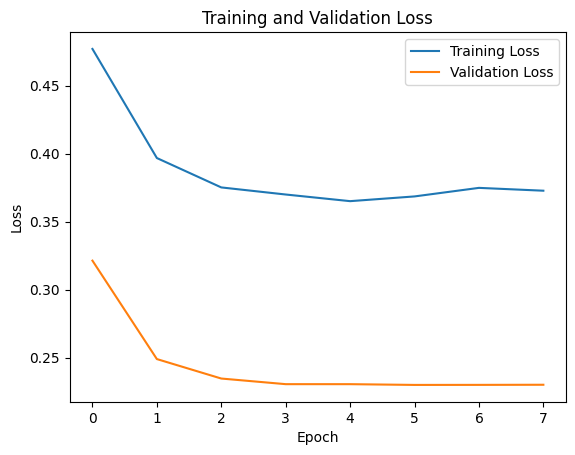

In [21]:
# loss plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

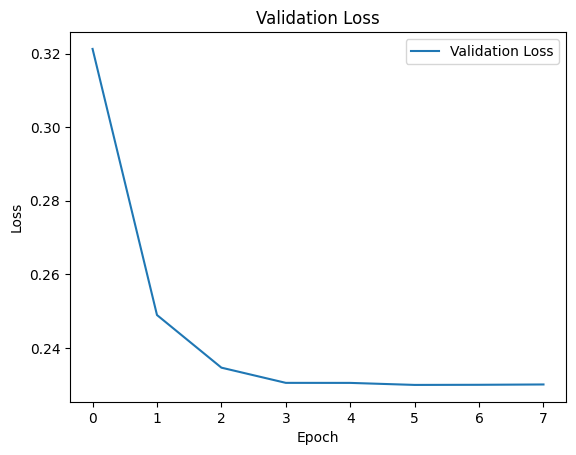

In [22]:
# loss plot
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

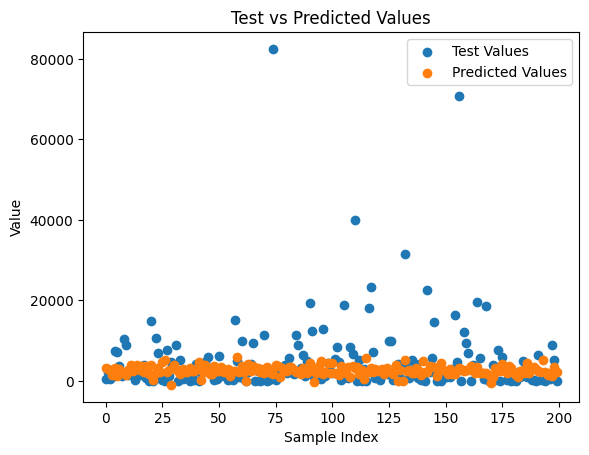

In [23]:
# compare to validation set
val_values = []
predicted_values = []
    
for visuals, audio_embeds, targets in val_loader:
    visuals, audio_embeds, targets = visuals.to(DEVICE), audio_embeds.to(DEVICE), targets.to(DEVICE)
    visual_embeds = autoencoder.getembedding(visuals).detach()
    outputs = ensemble_model.forward(visual_embeds, audio_embeds).detach()
    #print('target',targets)
    targets = torch.tensor(output_scaler.inverse_transform(targets.numpy()), dtype=torch.float32)
    outputs = torch.tensor(output_scaler.inverse_transform(outputs.numpy()), dtype=torch.float32)
        
    # Append the values
    val_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

val_values = list(np.array(val_values).squeeze())
predicted_values = list(np.array(predicted_values).squeeze())

plt.scatter(range(len(val_values)), val_values, label='Test Values')
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()

In [24]:
# Inspect first N
N = 10
val_check = [round(i, 2) for i in val_values][:N]
predicted_check = [round(i, 2) for i in predicted_values][:N]
print('Val', val_check)
print('Predict', predicted_check)

Val [462.4, 2100.0, 413.8, 855.7, 7500.0, 7100.0, 3700.0, 1100.0, 10300.0, 9000.0]
Predict [3302.94, 2944.43, 2724.03, 1548.0, 3284.05, 1106.03, 3054.24, 2096.38, 1920.22, 1370.98]


In [25]:
# get MSE for the vaildation set
mse = mean_squared_error(val_values, predicted_values)
print(f'MSE: {mse:.2f}, Lenght: {len(val_values)}')

MSE: 90061716.74, Lenght: 200


In [26]:
train_values = []

for visuals, audio_embeds, targets in train_loader:
    visuals, audio_embeds, targets = visuals.to(DEVICE), audio_embeds.to(DEVICE), targets.to(DEVICE)
    targets = torch.tensor(output_scaler.inverse_transform(targets.numpy()), dtype=torch.float32)
    # Append the values
    train_values.extend(targets.tolist())

train_values = list(np.array(train_values).squeeze())

In [27]:
train_mean = list(np.full((len(val_values),), np.mean(train_values)))

# get MSE for the vaildation set
train_mean_mse = mean_squared_error(val_values, train_mean)
print(f'MSE: {train_mean_mse:.2f}, Lenght: {len(val_values)}')

MSE: 90648366.92, Lenght: 200


In [28]:
np.mean(val_values)

4805.688512434959

In [29]:
print('Better than train mean?')
mse < train_mean_mse

Better than train mean?


True

In [30]:
train_mean_mse

90648366.9240908

In [31]:
mse

90061716.7425849

In [32]:
(mse - train_mean_mse) / train_mean_mse

-0.006471712634350778

In [34]:
train_median = list(np.full((len(val_values),), np.median(train_values)))

# get MAE for the vaildation set
train_median_mae = mean_absolute_error(val_values, train_median)
print(f'MAE: {train_median_mae:.2f}, Lenght: {len(val_values)}')

MAE: 4147.82, Lenght: 200


In [35]:
print('Better than train median?')
mae < train_median_mae

Better than train median?


False

In [36]:
# Preprocessing paramemter & ConvLSTMAutoencoder
DEVICE = 'cpu' #get_device() # CPU or GPU
DATASET = 'video_pack_100_holdout'
FRAME_SKIP = 200 # how many frame to skip, reduce depth
SHRINK = 8 # shrink the scale (H x W)//N
NORMALIZE = False # normalize the pixel to 0 to 1
PAD_ALL = False # pad all tensors with max depth
BATCH_SIZE = 4

In [37]:
x_dir, y_dir = get_base_tensor_directories(input_type=DATASET)

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)]) 
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])

In [38]:
from sklearn.preprocessing import StandardScaler
output_scaler = StandardScaler()

# load ensemble data
x_data, y_data = get_ensemble_data(x_files, DATASET)
y_data = torch.stack(y_data)
y_data = y_data.squeeze(1)

y_data = torch.tensor(output_scaler.fit_transform(y_data.numpy()), dtype=torch.float32)


test_loader = list(zip(x_data, y_data))
test_loader = DataLoader(test_loader, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch_ensemble)

print(f'Test set size: {len(y_data)}')

Test set size: 100


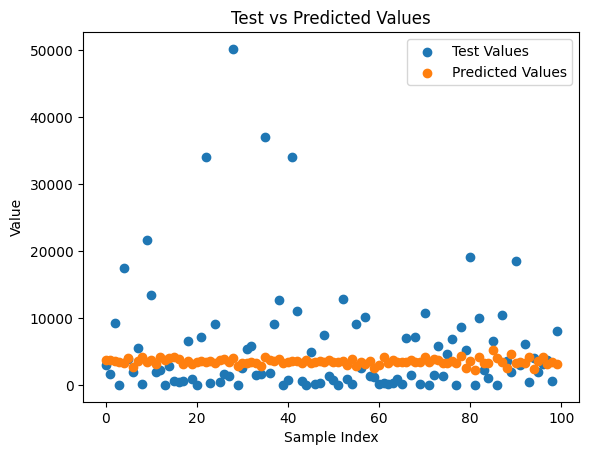

In [39]:
# compare to validation set
test_values = []
predicted_values = []
    
for visuals, audio_embeds, targets in test_loader:
    visuals, audio_embeds, targets = visuals.to(DEVICE), audio_embeds.to(DEVICE), targets.to(DEVICE)
    visual_embeds = autoencoder.getembedding(visuals).detach()
    outputs = ensemble_model.forward(visual_embeds, audio_embeds).detach()
    #print('target',targets)
    targets = torch.tensor(output_scaler.inverse_transform(targets.numpy()), dtype=torch.float32)
    outputs = torch.tensor(output_scaler.inverse_transform(outputs.numpy()), dtype=torch.float32)
        
    # Append the values
    test_values.extend(targets.tolist())
    predicted_values.extend(outputs.tolist())

test_values = list(np.array(test_values).squeeze())
predicted_values = list(np.array(predicted_values).squeeze())

plt.scatter(range(len(test_values)), test_values, label='Test Values')
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()

In [40]:
train_mean = list(np.full((len(test_values),), np.mean(train_values)))

# get MSE for the vaildation set
train_mean_mse = mean_squared_error(test_values, train_mean)
print(f'MSE: {train_mean_mse:.2f}, Lenght: {len(test_values)}')

MSE: 73562767.41, Lenght: 100


In [41]:
# get MSE for the vaildation set
mse = mean_squared_error(test_values, predicted_values)
print(f'MSE: {mse:.2f}, Lenght: {len(test_values)}')

MSE: 72965003.12, Lenght: 100


In [42]:
# get MSE for the vaildation set
mae = mean_absolute_error(test_values, predicted_values)
print(f'MAE: {mae:.2f}, Lenght: {len(test_values)}')

MAE: 4891.08, Lenght: 100


In [43]:
train_median = list(np.full((len(test_values),), np.median(train_values)))

# get MAE for the vaildation set
train_median_mae = mean_absolute_error(test_values, train_median)
print(f'MAE: {train_median_mae:.2f}, Lenght: {len(test_values)}')

MAE: 4729.21, Lenght: 100


In [44]:
print('Better than train mean?')
mse < train_mean_mse

Better than train mean?


True

In [45]:
print('Better than train median?')
mae < train_median_mae

Better than train median?


False